In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
eeci_colors = ['#E50068','#574145','#009070','#7500a0','#ffbfeb','#00C8A4','#a800e5','#4d4e51','#BEA5A9','#ebf1f7']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=eeci_colors) 

In [3]:
UCam_ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]

results_file = os.path.join('..','results', 'prediction_tests_diff-train-test.csv')
gen_results = pd.read_csv(results_file)
mae_results = gen_results[gen_results['Metric']=='gmnMAE']

correlations_dir = os.path.join('..','data','analysis','correlations')
wass_corrs = pd.read_csv(os.path.join(correlations_dir,'wasserstein.csv'),index_col=0)
mae_corrs = pd.read_csv(os.path.join(correlations_dir,'mae.csv'),index_col=0)
rmse_corrs = pd.read_csv(os.path.join(correlations_dir,'rmse.csv'),index_col=0)

models = ['analysis\conv_0',r'analysis\resmlp_0','analysis\linear_0','TFT']
model_names = ['Conv','ResMLP','Linear','TFT']
metric_scores = {}
for model in models:
    metric_scores[model] = [[float(mae_results[(mae_results['Model Name'] == model) & (mae_results['Train Building'] == t_id)]['L%s'%p_id]) for p_id in UCam_ids] for t_id in UCam_ids]

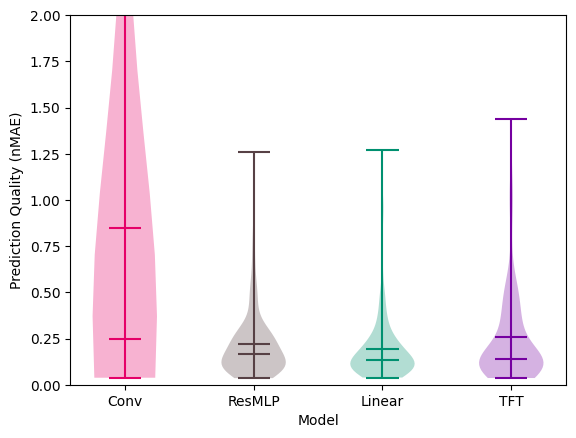

In [4]:
# Plot distribution of generalisation scores
fig,ax = plt.subplots()
for i,model in enumerate(models):
    ax.violinplot(np.array(metric_scores[model]).flatten(),[i],showmeans=True,showmedians=True)
ax.set_ylim(0,2)
ax.set_ylabel('Prediction Quality (nMAE)')
ax.set_xlabel('Model')
ax.set_xticks(list(range(len(models))))
ax.set_xticklabels(model_names)
plt.show()

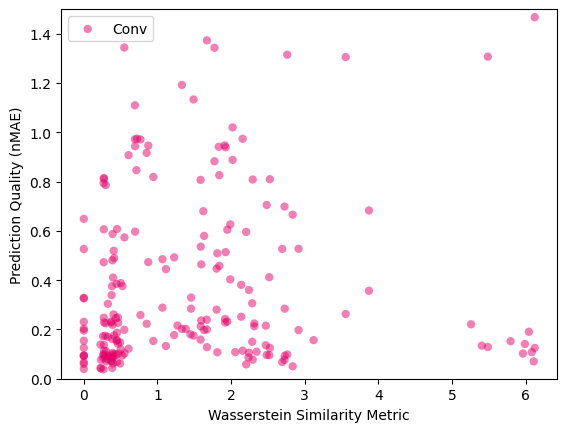

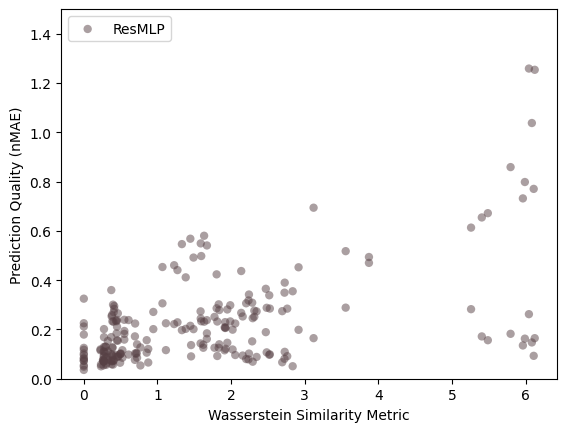

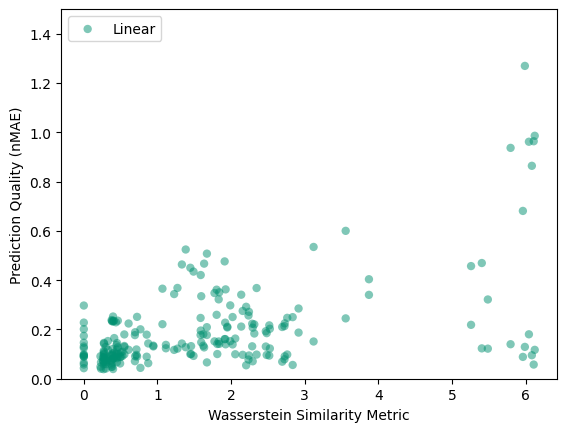

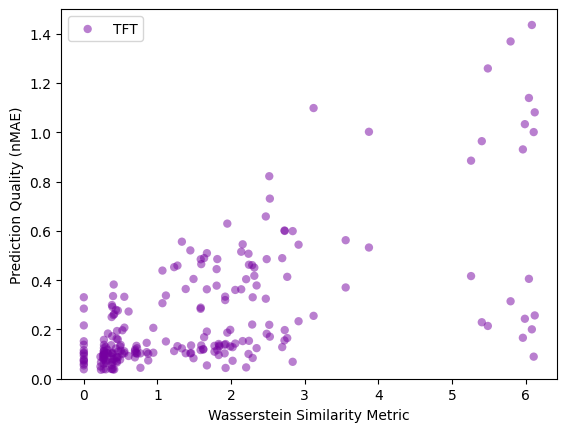

In [5]:
# Plot correlation between generalisation scores and wasserstein distance
for i,model in enumerate(models):
    fig,ax = plt.subplots()

    ax.scatter(wass_corrs.to_numpy().flatten(),np.array(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0,1.5)
    ax.set_ylabel('Prediction Quality (nMAE)')
    ax.set_xlabel('Wasserstein Similarity Metric')
    plt.legend(fancybox=True, loc='upper left')
    plt.show()

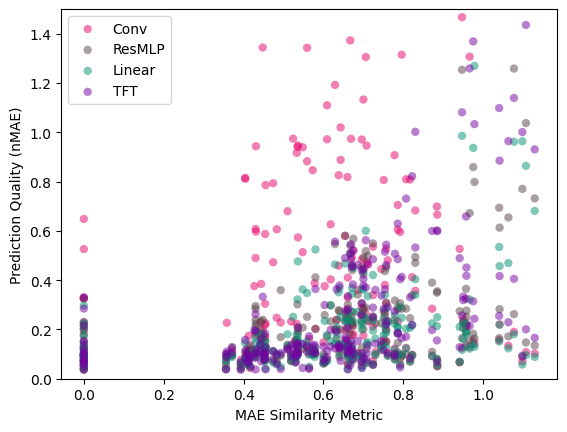

In [6]:
# Plot correlation between generalisation scores and mae
fig,ax = plt.subplots()
for i,model in enumerate(models):
    ax.scatter(mae_corrs.to_numpy().flatten(),np.array(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
ax.set_ylim(0,1.5)
ax.set_ylabel('Prediction Quality (nMAE)')
ax.set_xlabel('MAE Similarity Metric')
plt.legend(fancybox=True, loc='upper left')
plt.show()

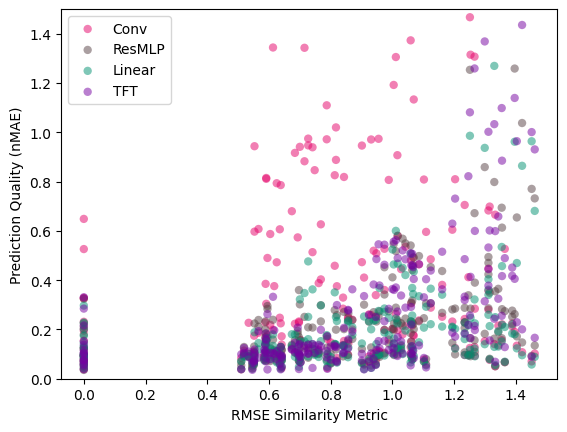

In [7]:
# Plot correlation between generalisation scores and rmse
fig,ax = plt.subplots()
for i,model in enumerate(models):
    ax.scatter(rmse_corrs.to_numpy().flatten(),np.array(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
ax.set_ylim(0,1.5) # conv results go up to 9
ax.set_ylabel('Prediction Quality (nMAE)')
ax.set_xlabel('RMSE Similarity Metric')
plt.legend(fancybox=True, loc='upper left')
plt.show()